# Distributions

In the first chapter, having cleaned and validated your data, you began exploring it by using histograms to visualize distributions. In this chapter, you'll learn how to represent distributions using Probability Mass Functions (PMFs) and Cumulative Distribution Functions (CDFs). You'll learn when to use each of them, and why, while working with a new dataset obtained from the General Social Survey.

# 1. Probability mass functions


1.2 Make a PMF

The GSS dataset has been pre-loaded for you into a DataFrame called gss. You can explore it in the IPython 
Shell to get familiar with it.

In this exercise, you'll focus on one variable in this dataset, 'year', which represents the year each 
respondent was interviewed.

You can access the Pmf classvia the empiricaldist library 
https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb

and https://github.com/AllenDowney/ExploratoryDataAnalysis/blob/master/distribution.ipynb

The Pmf class

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from empiricaldist import Pmf

def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

class Pmf(pd.Series):
    
    def __init__(self, seq, name='Pmf', **options):
        """Make a PMF from a sequence.
        
        seq: sequence of values
        name: string
        sort: boolean, whether to sort the values, default True
        normalize: boolean, whether to normalize the Pmf, default True
        dropna: boolean, whether to drop NaN, default True
        """
        # get the sort flag
        sort = options.pop('sort', True)

        # normalize unless the caller said not to
        underride(options, normalize=True)
        
        # put the seq in a Series so we can use value_counts
        series = pd.Series(seq, copy=False)
        
        # make the counts
        # by default value_counts sorts by frequency, which
        # is not what we want
        options['sort'] = False
        counts = series.value_counts(**options)
        
        # sort by value
        if sort:
            counts.sort_index(inplace=True)
            
        # call Series.__init__
        super().__init__(counts, name=name)

    @property
    def qs(self):
        return self.index.values

    @property
    def ps(self):
        return self.values

    def __call__(self, qs):
        """Look up a value in the PMF."""
        return self.get(qs, 0)

    def normalize(self):
        """Normalize the PMF."""
        self /= self.sum()

    def bar(self, **options):
        """Plot the PMF as a bar plot."""
        underride(options, label=self.name)
        plt.bar(self.index, self.values, **options)

    def plot(self, **options):
        """Plot the PMF with lines."""
        underride(options, label=self.name)
        plt.plot(self.index, self.values, **options)

In [28]:
# from empiricaldist import Pmf
gss = pd.read_hdf('C:\\Users\\yazan\\Desktop\\Data_Analytics\\7-Exploratory Data Analysis in Python\\datasets\\gss.hdf5','gss')

# Compute the PMF for year and set normalize to False
pmf_year = Pmf(gss.year, normalize=False)

# Print the result
print(pmf_year)

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: Pmf, dtype: int64


In [29]:
# from empiricaldist import Pmf
gss = pd.read_hdf('C:\\Users\\yazan\\Desktop\\Data_Analytics\\7-Exploratory Data Analysis in Python\\datasets\\gss.hdf5','gss')

# Compute the PMF for year and set normalize to True
pmf_year = Pmf(gss.year, normalize=True)

# Print the result
print(pmf_year)

1972    0.025822
1973    0.024077
1974    0.023757
1975    0.023853
1976    0.023997
1977    0.024493
1978    0.024525
1980    0.023501
1982    0.029776
1983    0.025598
1984    0.023581
1985    0.024557
1986    0.023533
1987    0.029120
1988    0.023709
1989    0.024605
1990    0.021964
1991    0.024285
1993    0.025710
1994    0.047898
1996    0.046489
1998    0.045337
2000    0.045097
2002    0.044264
2004    0.045016
2006    0.072199
2008    0.032386
2010    0.032722
2012    0.031601
2014    0.040630
2016    0.045897
Name: Pmf, dtype: float64


1.2 Plot a PMF

Now let's plot a PMF for the age of the respondents in the GSS dataset. The variable 'age' contains respondents' age in years.

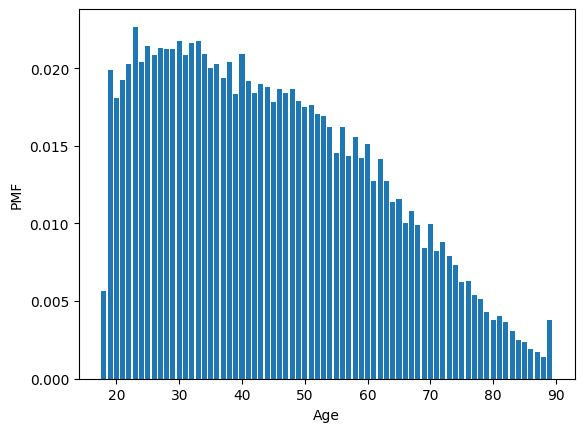

In [30]:
# Select the age column
age = gss['age']

# Make a PMF of age
pmf_age = Pmf(age)

# Plot the PMF
pmf_age.bar(label='age')

# Label the axes
plt.xlabel('Age')
plt.ylabel('PMF')
plt.show()

# 2. Cumulative distribution functions

2.2 Make a CDF

In this exercise, you'll make a CDF and use it to determine the fraction of respondents in the GSS dataset who are OLDER than 30.

The GSS dataset has been preloaded for you into a DataFrame called gss.

As with the Pmf class from the previous lesson, the Cdf class has been created, and you can access it via the empiricaldist library.

https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb

and https://github.com/AllenDowney/ExploratoryDataAnalysis/blob/master/distribution.ipynb

The CDF Class

In [31]:
from scipy.interpolate import interp1d
import pandas as pd

class Cdf(pd.Series):

    def __init__(self, seq, name='Cdf', **options):
        """Make a CDF from a sequence.
        
        seq: sequence of values
        name: string
        sort: boolean, whether to sort the values, default True
        normalize: boolean, whether to normalize the Cdf, default True
        dropna: boolean, whether to drop NaN, default True
        """
        # get the normalize option
        normalize = options.pop('normalize', True)
        
        # make the PMF and CDF
        pmf = Pmf(seq, normalize=False, **options)
        cdf = pmf.cumsum()
        
        # normalizing the CDF, rather than the PMF,
        # avoids floating-point errors and guarantees
        # that the last proability is 1.0
        if normalize:
            cdf /= cdf.values[-1]
        super().__init__(cdf, name=name, copy=False)
        
    @property
    def qs(self):
        return self.index.values

    @property
    def ps(self):
        return self.values

    @property
    def forward(self):
        return interp1d(self.qs, self.ps,
                        kind='previous',
                        assume_sorted=True,
                        bounds_error=False,
                        fill_value=(0,1))

    @property
    def inverse(self):
        return interp1d(self.ps, self.qs,
                        kind='next',
                        assume_sorted=True,
                        bounds_error=False,
                        fill_value=(self.qs[0], np.nan))

    def __call__(self, qs):
        return self.forward(qs)

    def percentile_rank(self, qs):
        return self.forward(qs) * 100

    def percentile(self, percentile_ranks):
        return self.inverse(percentile_ranks / 100)

    def step(self, **options):
        """Plot the CDF as a step function."""
        underride(options, label=self.name, where='post')
        plt.step(self.index, self.values, **options)

    def plot(self, **options):
        """Plot the CDF as a line."""
        underride(options, label=self.name)
        plt.plot(self.index, self.values, **options)

In [32]:
# Select the age column
age = gss['age']

# Compute the CDF of age
cdf_age = Cdf(age)

# Calculate the CDF of 30
print(cdf_age(30))

0.2539137136526389


Question:

What fraction of the respondents in the GSS dataset are OLDER than 30?

Possible Answers:

- Approximately 75% (True)
- Approximately 65%
- Approximately 45%
- Approximately 25%

2.2 Compute IQR

The interquartile range (IQR) is the difference between the 75th and 25th percentiles. It is a measure of variability that is robust in the presence of errors or extreme values.

In this exercise, you'll compute the interquartile range of income in the GSS dataset. Income is stored in the 'realinc' column, and the CDF of income has already been computed and stored in cdf_income.

In [33]:
# To use inverse import numpy
import numpy as np

# Select the income column
income = gss['realinc']

# Compute the CDF of age
cdf_income = Cdf(income)

# Calculate the 75th percentile 
percentile_75th = cdf_income.inverse(0.75)

# Calculate the 25th percentile
percentile_25th = cdf_income.inverse(0.25)

# Calculate the interquartile range
iqr = percentile_75th - percentile_25th

# Print the interquartile range
print(iqr)

29676.0


Question:
What is the interquartile range (IQR) of income in the GSS dataset?

Possible Answers:
- Approximately 29676 (True)
- Approximately 26015
- Approximately 34702
- Approximately 30655

2.3 Plot a CDF

The distribution of income in almost every country is long-tailed; that is, there are a small number of people with very high incomes.

In the GSS dataset, the variable 'realinc' represents total household income, converted to 1986 dollars. We can get a sense of the shape of this distribution by plotting the CDF.

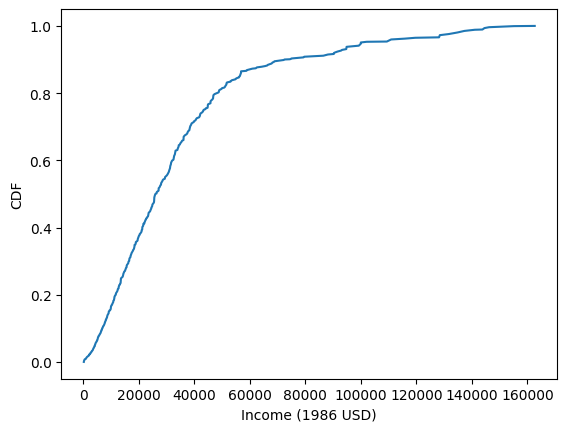

In [34]:
# Select realinc
income = gss['realinc']

# Make the CDF
cdf_income = Cdf(income)

# Plot it
cdf_income.plot()

# Label the axes
plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.show()